# fbb scheleton notebook for PUI2016 HW6

In [1]:
from __future__ import print_function, division
import geopandas as gp
import pandas as pd
import pylab as pl
import os
import json
import seaborn as sns
import matplotlib as plt

#s = json.load( open(os.getenv('PUI2016')+'/fbb_matplotlibrc.json') )
#pl.rcParams.update(s)
if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline
print(os.getenv("PUIDATA"))

Populating the interactive namespace from numpy and matplotlib
/home/cusp/cjs676/PUIdata


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


I am using geopanda. that is **not required** for this particular exercise, but geopand works with geospacial data: the shape files that we get from pluto for example.

PLEASE REMEMBER: seed your random functions if you need to use any, label your axes clearly, comment your code, use PEP8!


## An interesting urban question is "can we measure and predict energy use based on observables that are easier to be acquired". For example the urban observatory at CUSP can monitor lights: they are a realtively easy observable. All you need is a camera, and a pipeline to process your data. But how does the light coming from a window relate to the total energy consumption? We generally postulate that light is a proxy for occupancy, and that occupancy is a good predictor of energy consumption.
## So let's test if the last link holds. If we have data on the energy consumed by a __building__ how well does that relate to the number of units in the building?

## Data on energy consumption can be found here for the city of NY https://data.cityofnewyork.us/Environment/Energy-and-Water-Data-Disclosure-for-Local-Law-84-/rgfe-8y2z  

## Either obtain the data through the API or download the csv file, and move it to $PUIDATA

## However this datasets does not have the number of units. We can find that in the Pluto dataset.

## Reading in the Pluto data for manhattan, which will give me the number of units ber building   Manhattan/MNMapPLUTO.shp

In [2]:
##This part downloads the file. I had to move it externally in the terminal as I am not sure why this section here which is supposed to move the file does not work.

if not os.path.isfile(os.getenv("PUIDATA") + "rows.csv?accessType=DOWNLOAD"):
    if os.path.isfile("rows.csv?accessType=DOWNLOAD"):
            # if in the current dir just move it
        if os.system("mv " +  "rows.csv?accessType=DOWNLOAD" + os.getenv("PUIDATA")):
            print ("Error moving file!, Please check!")
        #otherwise start looking for the zip file
    else:
        if not os.path.isfile(os.getenv("PUIDATA") + "rows.csv?accessType=DOWNLOAD"):
            if not os.path.isfile("rows.csv?accessType=DOWNLOAD"):
                os.system("curl -O https://data.cityofnewyork.us/api/views/rgfe-8y2z/rows.csv?accessType=DOWNLOAD")
                  
                ###  To move it I use the os.system() functions to run bash commands with arguments
            os.system("mv " + "rows.csv?accessType=DOWNLOAD" + os.getenv("PUIDATA")) 
            ### unzip the csv 
            #os.system("unzip " + os.getenv("PUIDATA") + "/" + datestring + "-citibike-tripdata.zip")
            ## NOTE: old csv citibike data had a different name structure. 
            #if '2014' in datestring:
                #os.system("mv " + datestring[:4] + '-' +  datestring[4:] + 
                          #"\ -\ Citi\ Bike\ trip\ data.csv " + datestring + "-citibike-tripdata.csv")
                #os.system("mv " + datestring + "-citibike-tripdata.csv " + os.getenv("PUIDATA"))
    ### One final check:
if not os.path.isfile(os.getenv("PUIDATA") + "/" + "nrg.csv"):
    print ("WARNING!!! something is wrong: the file is not there!")

else:
    print ("file in place, you can continue")
    

Error moving file!, Please check!
file in place, you can continue


In [3]:
#Since I was unable to read and move the file automatically I 
#https://www1.nyc.gov/site/planning/data-maps/open-data/dwn-pluto-mappluto.page
    
    
    
os.system('curl -O https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/mn_mappluto_16v1.zip')
# I dont know why I cant move things around through this code. The type I used above failed and I thought if I tred what is driectly it may work.  
# It did not. I dont know why my code wont work.
os.system("mv " + "~PUI2016_cjs676/HW6_cjs676/mn_mappluto_16v1.zip" + os.getenv("PUIDATA"))

os.system(os.getenv("PUIDATA") + "unzip" + "mn_mappluto_16v1.zip")
if not os.path.isfile(os.getenv("PUIDATA") + "/" + "MNMapPLUTO.shp"):
    print ("WARNING!!! something is wrong: the file is not there!")

else:
    print ("file in place, you can continue")

file in place, you can continue


In [4]:
nrg = pd.read_csv(os.getenv("PUIDATA") + "/" + "nrg.csv")

In [5]:
nrg.columns
#nrg.head(5)

Index(['Record Number', 'NYC Borough, Block, and Lot (BBL)',
       'Co-reported BBL Status', 'BBLs Co-reported',
       'Reported NYC Building Identificaiton Numbers (BINs)', 'Street Number',
       'Street Name', 'Borough', 'Zip Code',
       'DOF Benchmarking Submission Status', 'Site EUI(kBtu/ft2)',
       'Weather Normalized Site EUI(kBtu/ft2)', 'Source EUI(kBtu/ft2)',
       'Weather Normalized Source EUI(kBtu/ft2)',
       'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)',
       'Automatic Water Benchmarking Eligible', 'Reported Water Method',
       'ENERGY STAR Score', 'Total GHG Emissions(MtCO2e)',
       'Direct GHG Emissions(MtCO2e)', 'Indirect GHG Emissions(MtCO2e)',
       'Reported Property Floor Area (Building(s)) (ft²)',
       'DOF Property Floor Area (Buildngs and Parking)(ft2)',
       'Primary Property Type - Self Selected', 'DOF Number of Buildings'],
      dtype='object')

In [6]:
# Code Below gives different values than your example. I then decided to read the .shp file 
#bsize = pd.read_csv(os.getenv("PUIDATA") + "/" + "MN.csv")
bsize = gp.read_file(os.getenv("PUIDATA") + "/" +  "MNMapPLUTO.shp")

In [7]:
#Now it is the same as the example
bsize.columns
#bsize.head(5)

Index(['APPBBL', 'APPDate', 'Address', 'AllZoning1', 'AllZoning2',
       'AreaSource', 'AssessLand', 'AssessTot', 'BBL', 'BldgArea', 'BldgClass',
       'BldgDepth', 'BldgFront', 'Block', 'BoroCode', 'Borough', 'BsmtCode',
       'BuiltCode', 'BuiltFAR', 'CB2010', 'CD', 'CT2010', 'ComArea', 'CommFAR',
       'CondoNo', 'Council', 'EDesigNum', 'Easements', 'ExemptLand',
       'ExemptTot', 'Ext', 'FacilFAR', 'FactryArea', 'FireComp', 'GarageArea',
       'HealthArea', 'HistDist', 'IrrLotCode', 'LandUse', 'Landmark', 'Lot',
       'LotArea', 'LotDepth', 'LotFront', 'LotType', 'LtdHeight', 'MAPPLUTO_F',
       'NumBldgs', 'NumFloors', 'OfficeArea', 'OtherArea', 'Overlay1',
       'Overlay2', 'OwnerName', 'OwnerType', 'PLUTOMapID', 'PolicePrct',
       'ProxCode', 'ResArea', 'ResidFAR', 'RetailArea', 'SHAPE_Area',
       'SHAPE_Leng', 'SPDist1', 'SPDist2', 'Sanborn', 'SanitBoro', 'SanitDist',
       'SanitSub', 'SchoolDist', 'SplitZone', 'StrgeArea', 'TaxMap',
       'Tract2010', 'UnitsRe

In [8]:
# make sure you clean up your data and throw away columns you do not need!
#It seems we do not need most of the columns. I am going to get rid of most of them!
#THe Question appears to be "If we have data on the energy consumed by a building how well does that relate to the number of units in the building?
#The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' 
#and then the buildings area, u'Reported Property Floor Area (Building(s)) (ft²)'

nrg2 = nrg[['NYC Borough, Block, and Lot (BBL)','Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']]
nrg2.head(5)



,"NYC Borough, Block, and Lot (BBL)",Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.000410e+09,NaN,918919
1,4.021460e+09,NaN,NaN
2,2.027620e+09,NaN,64200
3,1.006700e+09,NaN,NaN
4,2.048300e+09,NaN,50000


In [9]:
bsize2 = bsize[['BBL', 'UnitsTotal']]
bsize2.head(5)

,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50
2,1.016800e+09,10
3,1.013850e+09,32
4,1.011970e+09,26


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3d8e57c88>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff3d93bfe10>]], dtype=object)

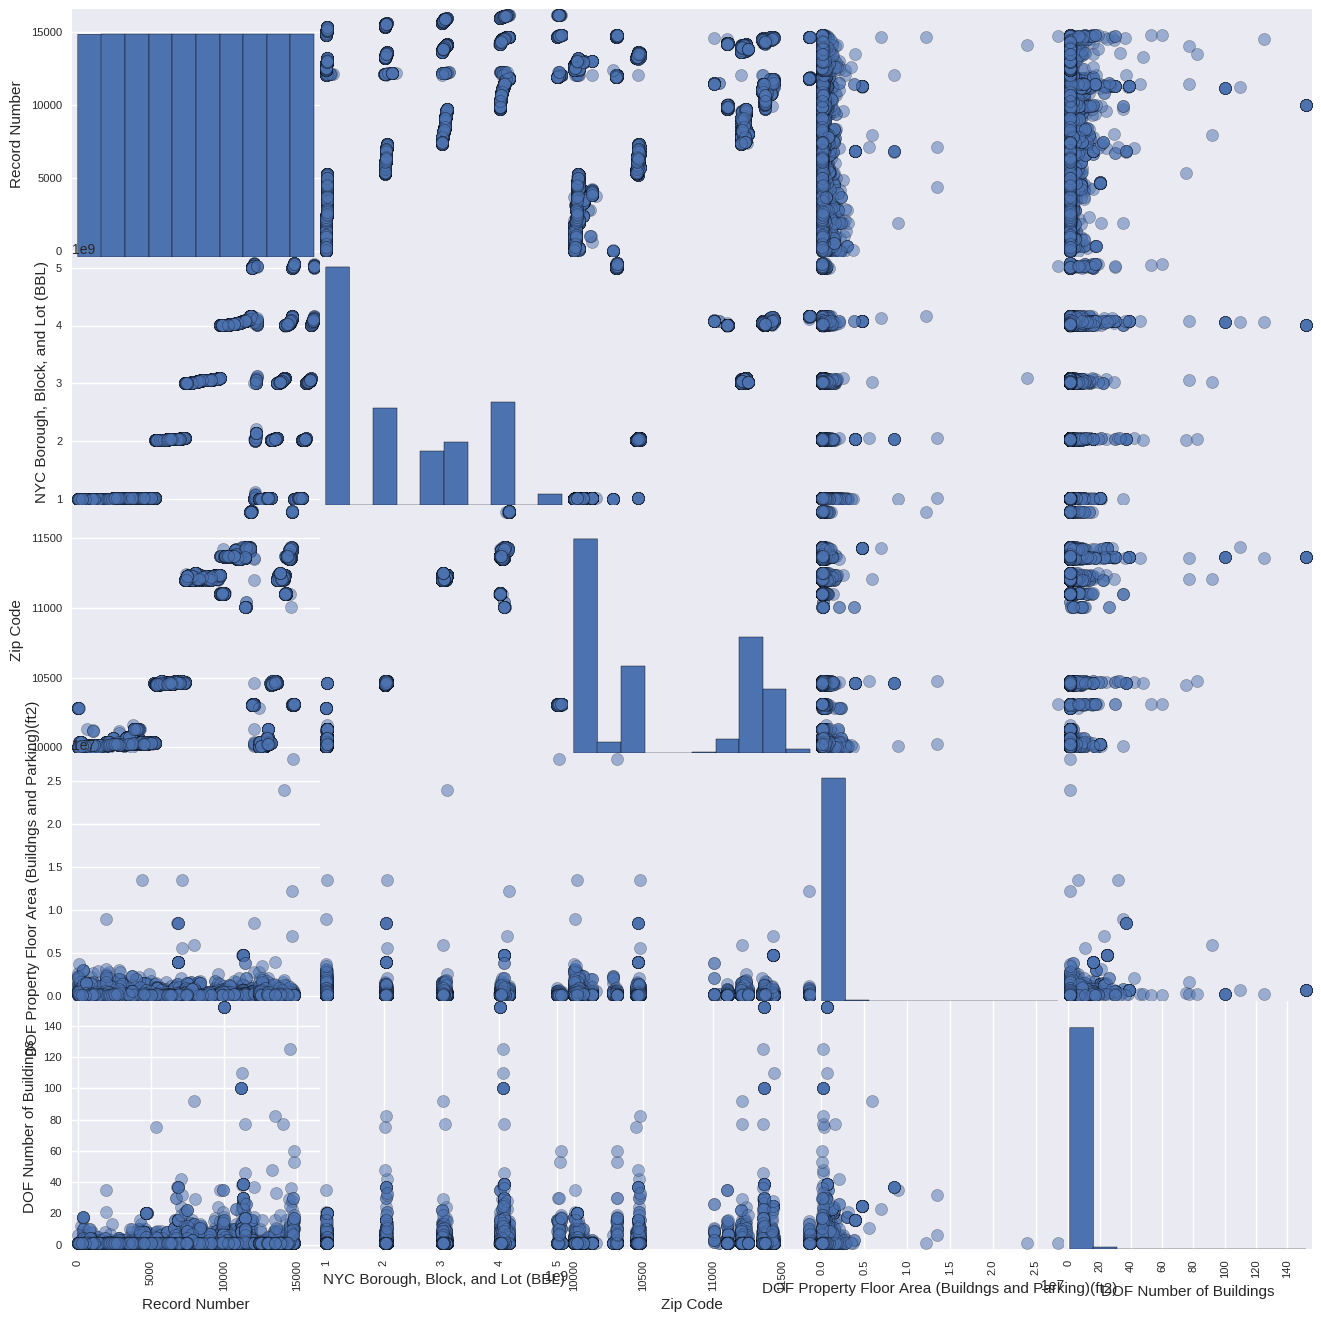

In [10]:
#try make a scatter plot of nrg. Few columns will plot
from pandas.tools.plotting import scatter_matrix
scatter_matrix (nrg, s=300, figsize=(16, 16))

In [11]:
#try make a scatter plot of nrg. Few columns will plot
#from pandas.tools.plotting import scatter_matrix
#scatter_matrix (nrg2, s=300, figsize=(16, 16))

Figure 1: scatter matrix of all numerical values in the files.

This kind of plot shows correlations between variables, but it will also show me what can and cannot be plotted trivially in my dataset. Here only a few columns can be plotted: those that contain only numbers (and possibly NaN's), but most columns contain rows that cannot be converted to float (e.g. entries like 'See Primary BBL' in several rows for the energy dataframe 'Site EUI(kBtu/ft2) ' column) , so Pandas refuses to plot them, cause it does not know what to do with those entries. The columns I am interested in are in fact u'Site EUI(kBtu/ft2)' which is a measure of the energy consumed PER SQ FOOT by a building, and then the building area: for eg. u'Reported Property Floor Area (Building(s)) (ft²)'. Neither gets plotted: i need to remove all values that cannot conver to float in order to use the columns and convert them to float arrays and do math with them.
Below I created a function that returns True if what is passed as argument can be converted to a float, and False otherwise. I do it with the Try/Except structure. it is a very useful python functionality that you should look into.
This has to be done entry by entry: if you give it a series you get error "cannot convert the series to..."
However you can pass it a whole array by using it in conjunction with np.vectorize (look up the syntax!) which will implement a for loop for you under the hood to pass the series entry by entry to your function.

In [20]:

def canconvert(mydata):
    try :
        float(mydata)
        return True
    except ValueError:
        return False

#canconvert(np.vectorize(nrg2),) 

#THe Following methods were
#FOund here http://stackoverflow.com/questions/25952790/convert-pandas-series-from-dtype-object-to-float-and-errors-to-nans
#And Here http://stackoverflow.com/questions/15891038/pandas-change-data-type-of-columns
#pandas.to_numeric(arg, errors='raise')
#df[['col2','col3']] = df[['col2','col3']].apply(pd.to_numeric)
#df.apply(lambda x: pd.to_numeric(x, errors='ignore'))

#nrg2[['NYC Borough, Block, and Lot (BBL)','Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']] = nrg2[['NYC Borough, Block, and Lot (BBL)','Site EUI(kBtu/ft2)', 'Reported Property Floor Area (Building(s)) (ft²)']].apply(pd.to_numeric( errors='coerce'))
#nrg2.apply(lambda x: pd.to_numeric(x, errors='ignore'))

#nrg2.head(5)


#dtype(nrg2['NYC Borough, Block, and Lot (BBL)'])
#dtype(nrg2['Site EUI(kBtu/ft2)'])
#dtype(nrg2['Reported Property Floor Area (Building(s)) (ft²)'])


#My lambda x didnt work because it did not change all the . I am going to try something else 'brute force'
#Found here: http://stackoverflow.com/questions/36874246/convert-a-column-in-pandas-dataframe-from-string-to-float


nrg2['NYC Borough, Block, and Lot (BBL)'] = pd.to_numeric(nrg2['NYC Borough, Block, and Lot (BBL)'], errors='coerce')
#dtype(nrg2['NYC Borough, Block, and Lot (BBL)'])

nrg2['Site EUI(kBtu/ft2)'] = pd.to_numeric(nrg2['Site EUI(kBtu/ft2)'], errors='coerce')
#dtype(nrg2['Site EUI(kBtu/ft2)'])

nrg2['Reported Property Floor Area (Building(s)) (ft²)'] = pd.to_numeric(nrg2['Reported Property Floor Area (Building(s)) (ft²)'], errors='coerce')
#dtype(nrg2['Reported Property Floor Area (Building(s)) (ft²)'])

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [21]:
dtype(nrg2['NYC Borough, Block, and Lot (BBL)'])
#dtype(nrg2['Site EUI(kBtu/ft2)'])
#dtype(nrg2['Reported Property Floor Area (Building(s)) (ft²)'])

dtype('float64')

In [22]:
#bsize2.apply(lambda x: pd.to_numeric(x, errors='coerce'))
#bsize2.head(15)
#['BBL', 'UnitsTotal']
#Again, since this equation'bsize2.apply(lambda x: pd.to_numeric(x, errors='coerce'))' did not convert all of the columns
#I am going to brute force convert the values

bsize2['BBL'] = pd.to_numeric(bsize['BBL'], errors='coerce')


bsize2['UnitsTotal'] = pd.to_numeric(bsize2['UnitsTotal'], errors='coerce')


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
#dtype(bsize2['BBL'])
dtype(bsize2['UnitsTotal'])
#Did not convert the Units total to a float. Hopefully that is fine. 

dtype('int64')

In [24]:
bsize2.head(5)

,BBL,UnitsTotal
0,1.015450e+09,18
1,1.007238e+09,50
2,1.016800e+09,10
3,1.013850e+09,32
4,1.011970e+09,26



Now for every column I care about I can create an array, call it for eg. indx, of True and False (a Boolean array) that i can use as an index to pick entries that I want to use from my arrays of interest. 

I can replace the entries that failed to be converted to 'NaN'
(because my function return Trues when I can convert and False otherwise i actuallly want the complementary array: ~indx) 

In [25]:

##check that your conversion worked: e.g.
#print (nrg2['NYC Borough, Block, and Lot (BBL)'].astype(float))
#print (nrg2['Site EUI(kBtu/ft2)'].astype(float))
#print (nrg2['Reported Property Floor Area (Building(s)) (ft²)'].astype(float))

#[...] check all columns you care about in both datasets. 
#Nan's are ok, but you must not get an error when you try the conversion
#the Pluto data is much better at not using spurious entries for numerical value columns. 
#but check you can use the columns you want

#bsize2.BBL.astype(float)
#bsize2.UnitsTotal.astype(float)

#this should not return an error
#notice i can use the attribute notation to refer to columns in bsize, 
#cause the column names do not have spaces!


In [26]:
#print (nrg2['NYC Borough, Block, and Lot (BBL)'].astype(float))
#print (nrg2['Site EUI(kBtu/ft2)'].astype(float))
#print (nrg2['Reported Property Floor Area (Building(s)) (ft²)'].astype(float))




indx = (np.vectorize(canconvert)(nrg2['Site EUI(kBtu/ft2)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg2['Site EUI(kBtu/ft2)'][~indx] = float('NaN')



indx = (np.vectorize(canconvert)(nrg2['NYC Borough, Block, and Lot (BBL)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg2['NYC Borough, Block, and Lot (BBL)'][~indx] = float('NaN')


indx = (np.vectorize(canconvert)(nrg2['Reported Property Floor Area (Building(s)) (ft²)']))
print ("invalid entries changed to NaN %d"%sum(indx))
nrg2['Reported Property Floor Area (Building(s)) (ft²)'][~indx] = float('NaN')

invalid entries changed to NaN 16170


/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/generic.py:4485: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2881: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


invalid entries changed to NaN 16170
invalid entries changed to NaN 16170


# MERGE THE DATASET
TO DO IT WE NEED A COMMON COLUMN: the building id BBL However the name of this variable (column) in the Energy dataset is 'NYC Borough, Block, and Lot (BBL)'. create a column 'BBL' in the nrg dataset to pass it to the 'on' keyword argument of the merge pandas method: pd.merge(..... on=['BBL']) will use the common column 'BBL' to join the information from the 2 datasets for each BBL value (check out the complete syntax!)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff3d91ffef0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7ff3d8bf2828>]], dtype=object)

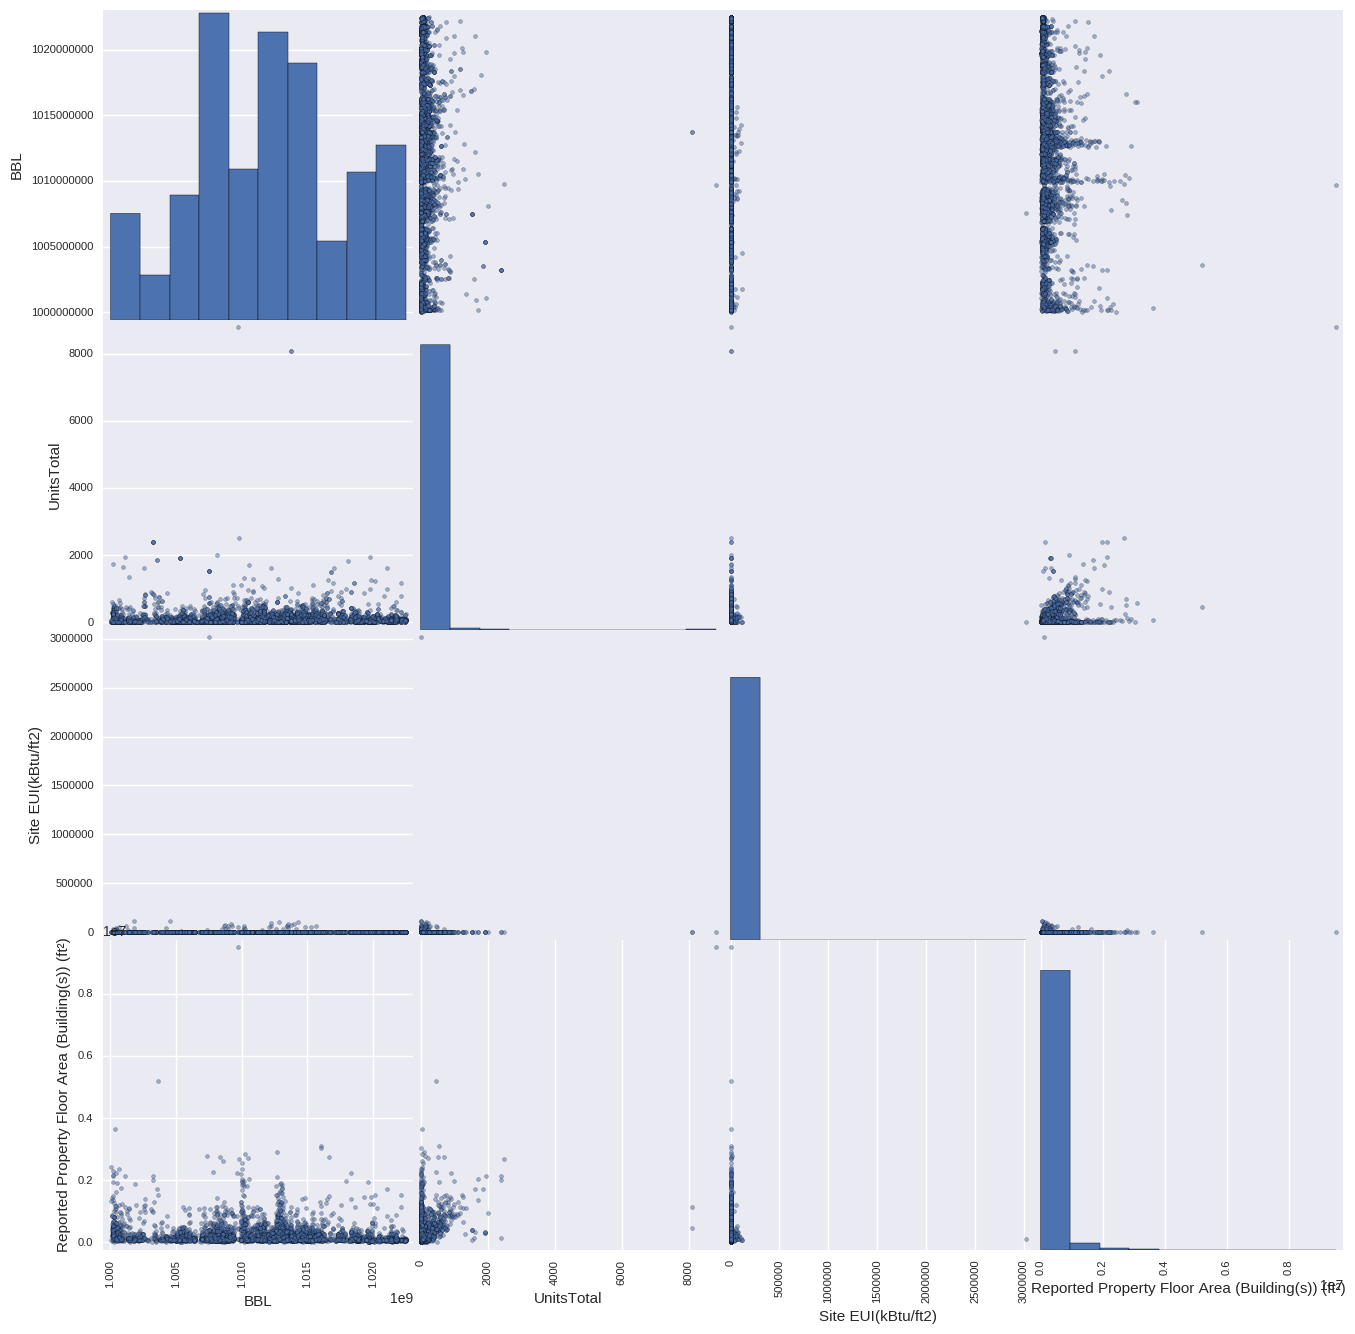

In [27]:
# prepare your BBL columns
#Rename
#df=df.rename(columns = {'two':'new_name'})
nrg2 = nrg2.rename(columns = {'NYC Borough, Block, and Lot (BBL)':'BBL'})

#merge
#DataFrame.merge(right, how='inner', on=None, left_on=None, right_on=None, left_index=False, 
#right_index=False, sort=False, suffixes=('_x', '_y'), copy=True, indicator=False)
bblnrgdata = bsize2.merge(nrg2, how='inner', on='BBL')

bblnrgdata.head(5)

# Now the scatter matrix plot should show more columns.
scatter_matrix (bblnrgdata, s=30, figsize=(16, 16))

once you have the dataframe with all the info you want, you want to plot Energy vs Number of Units in the Building. Remember: **Energy TOTAL, not per sq ft...** Here you can choose what you think makes more sense for the number of units: all units, residential units... 

**Make a  scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low Unit numbers while the Unit number range actually goes up to 8000. **


Make a second plot that zooms into the region where most points are by cutting your x and y axis plotted: e,g, use xlim=(1000,1e10), ylim=(1,1000), where the numbers to be plugged in depend on exactly what you chose to plot

I left my plots below as guidance. **Remember, each plot needs a descriptive caption, and axis labels**

In [28]:
bblnrgdata.head(5)


,BBL,UnitsTotal,Site EUI(kBtu/ft2),Reported Property Floor Area (Building(s)) (ft²)
0,1.007238e+09,50,68.7,95844.0
1,1.013850e+09,32,87.4,206989.0
2,1.021740e+09,72,140.4,52920.0
3,1.008830e+09,108,96.5,98359.0
4,1.008570e+09,138,36.4,154000.0


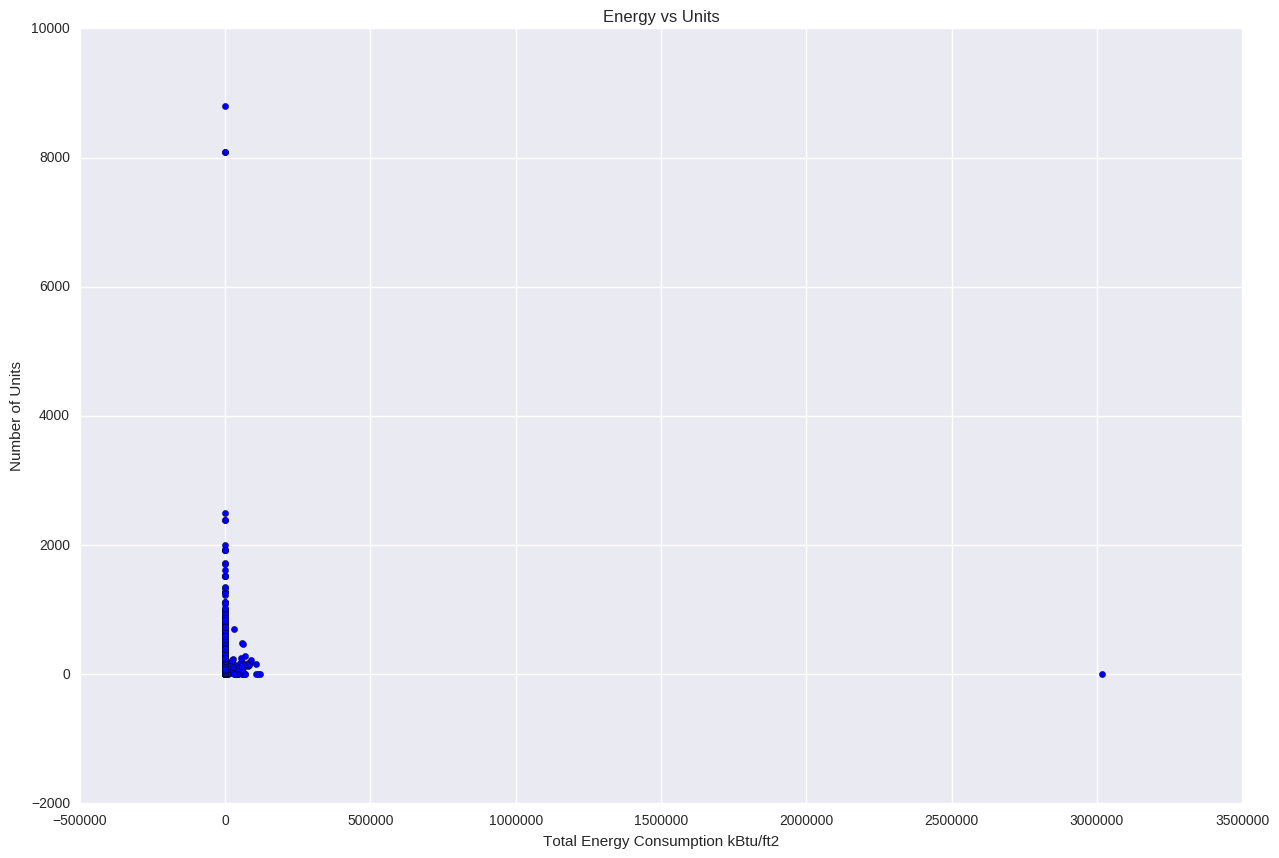

In [30]:


# first scatter plot
#Make a scatter plot first of Energy vs Units. It will look really bad be cause all the datapoints are at very low 
#Unit numbers while the Unit number range actually goes up to 8000.
# SEABORN (Works)
#g = sns.FacetGrid(bblnrgdata, ,size= 1)
#g.map(plt.scatter, 'Site EUI(kBtu/ft2)', 'UnitsTotal').add_legend()
#g.ax.set_title('Energy vs Units')

#Matplotlib
plt.figure(figsize=(15,10))
plt.scatter(bblnrgdata['Site EUI(kBtu/ft2)'], bblnrgdata['UnitsTotal'])
plt.xlabel('Total Energy Consumption kBtu/ft2')
plt.ylabel('Number of Units')
plt.title('Energy vs Units')



(1, 1000)

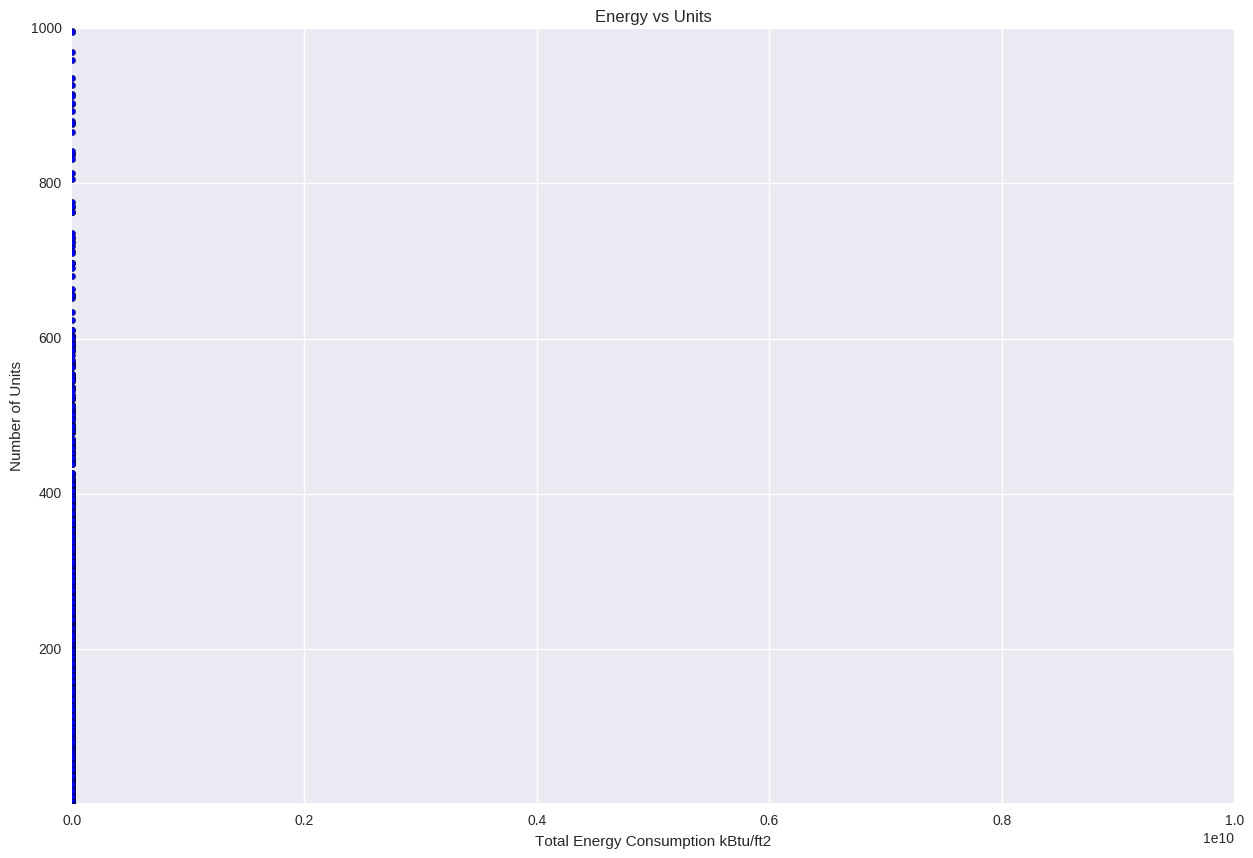

In [32]:
# zoomed in scatter plot
#MATPLOTLIB (I know it is best to just use one but I wanted to practice with a couple)
# MATPLOTLIB

plt.figure(figsize=(15,10))
plt.scatter(bblnrgdata['Site EUI(kBtu/ft2)'], bblnrgdata['UnitsTotal'])
plt.xlabel('Total Energy Consumption kBtu/ft2')
plt.ylabel('Number of Units')
plt.title('Energy vs Units')
plt.xlim(1000,1e10)
plt.ylim(1,1000)


when the points in a plot all look scrunched against the axis 

**Try to make a log plot instead**. In pandas you enable that with the keyword 'loglog' : bblnrgdata.plot(..... loglog=True)

NOTICE THAT YOU WILL STILL HAVE TO CUT YOUR DATASET! in my data I had a lot of energy datapoints that were exactly 0. I removed these "outliers" which I think are truly outliers in the sense that they are misreported numbers. you can remove the data that have nrg==0 (or nrg < some sensible threshold choice) by indexing your array: something like bblnrgdata_cut = bblnrgdata[bblnrgdata.nrg>1000]

Also I removed the buildings with several thousand units. points like that at the edge of my range would have a lot of "LEVERAGE", however they are not suprious entries like the 0, which i believe are missing values, or perhaps abandoned lots. these are good datapoint that i need to throw away functionally for my analysis to work, but that should be stated clearly.



In [ ]:
#log plot


Now fit a line through the data. you can use whatever you want to do it: statsmodels, scipy, any other package, or write your own minimization of the residuals

## BUT REMEMBER: we see hints of a linear relation in log space! so we want to fit a line to the log of our variables, not the variables themselves:
if you used statsmodels it would look something like this:


In [ ]:
X = sm.add_constant(np.log10(x))
linmodel = sm.OLS(np.log10(y), X, missing='drop').fit() # ignores entires 
                                                     # where x or y is NaN

## choose wisely which is your DEPENDENT and which is your INDEPENDENT variable. 
both for what you want to do logically (what changes as a functino of what) but also based on which variable has a 'sensible' distribution that allows you to fit a function to it: **you need your independent variable to span a large range, and to be spread somewhat evenly in the range, rather than just clustered in a spot** so in this case switching the independent and dependent variable may be a good idea.



1. **Fit a line** to Units vs Energy.
2. **Fit a line** to Energy vs Units.
3. **Evaluate which is better by calculating the chi square**. I provide a function for that or you can write your own. *Assume poisson statistics for the errors on the independent variable*. 
    The function is 
    
    chisq = $\sum_i \frac{(model(x_i) - data(x_i))^2 }{ error_i^2}$
    
    where the sum is over all datapoints, 
    
    for the i-th value with x value $x_i$ model is the predction of your fit for $x_i$, 
    
    $data(x_i)$ 
    is your observation, 
    
    and $error_i$ is $\sqrt{data(x_i)}$
    (but remember you worked in log space! What are the proper errors??)
    
4. **Fit a 2nd degree polynomial** to the Units vs Energy (with statsmodels.formulae.api.ols() for example passing the formula for a parabola, like we did in class. The formula for a 2nd deg polynomial is 
    $y = ax^2+bx+c$ .

5. **Compare the Units vs Energy line fit and the Units vs Energy 2-nd degree polynomial fit with the Likelihood ratio test**. The formula is:
    
    LR  =  -2 * (logLikelihood_Model1 - logLikelihood_Model2)
    
    where Model1 is the least complex (fewer parameters).
    
    Th logLikelihood can be extracted from the model summary when using statsmodels.
    
    Compare this LR statistics to a chi sq table (for example http://passel.unl.edu/Image/Namuth-CovertDeana956176274/chi-sqaure%20distribution%20table.PNG) and say if *at alpha = 0.05* Model1 is preferible to Model2. The LR is chi^2 distributed with number of degrees of freedom N_{DOF} = parameters_Model2 - parameters_Model1
    
    
    Also if you used statsmodels for the fit you can use the 
    compare_lr_test() method of your fit and verify you got the right answer.  Use the method compare_lr_test() of the most complex model of the 2 and pass it the result of stats models for the simpler fit 
    (e.g. smf.ols(formula = ...).fit().compare_lr_test(sm.OLS(...).fit()))



In [ ]:
# fits and plots here
# your plots should show datapoints (as scatter plot) and models (as lines)

In [ ]:
# my OLS summary. 
# Yours may be somewhat different depending on how you cut the data

In [ ]:
print ("LR : ", -2 * (-linemodel.llf - (-curvemodel.llf)))
print ("LR from statsmodels:", curvemodel.compare_lr_test(linemodel))

## Extra credit 1: calculate and plot the likelihood surface
Create a function that minimizes the residuals:

the residuals are the sum of the differences between data and model: in the case of a line fit model. Use the same function you created for the chi^2 test.

You should sum over each datapoints the residuals squared, which should look something like

(np.log(bblnrgdatacut.nrg) - np.log(bblnrgdatacut.UnitsTotal)*a+b )^2 / errors^2

where a and b are the parameters returned by the line fitter. 

For each data point you can calculate the model at different values : for example in a range B = np.arange (-100, 100, 1) for the intercept, and A = np.arange(-50.0, 50.0, 0.5) for the slope.


You can write it as a nested for loop (or challenge yourself and vectorize it!) with a loop inside another ranging all poissible combinations of the 2 variables (i use enumerate to get both an index from 0 to the size of my array, which i assign to i (and j) and the value of the array at that index - look up the syntax!):


Lsurface = np.zeros((len(A), len(B)))
for i,a in enumerate(A):
    for j,b in enumerate(B):
         Lsurface[i][j] = np.nansum(residuals(a,b,data,errors)) .....

this gives you a 2D array that represents your likelihood surface! What we do to find a good fit is find the minimum (lowest point) on this surface.
You can plot a surface (a 2D array) with pl.imshow(Lsurface) as a "heatmap" but when you do that you will find that the plot is very uninformative. just like you did before with the data, plot the log of it (pl.imshow(np.log(Lsurface)). Also make sure your x and y axes tick numbers represent the range of values, not the cell index, which is the default for imshow. Inputting your data in the cell below should give a plot similar to mine

In [ ]:
pl.figure(figsize=(10,10))
pl.title ("log likelihood surface", fontsize = 22)
pl.imshow(np.log(Lsurface), extent = [-50,50,100,-100], aspect=0.5)
pl.xlabel('slope', fontsize = 22)
pl.ylabel('intercept', fontsize = 22)
pl.colorbar()

## EXTRA CREDIT: get creative with the dataset. can you make an insigntful plot to show any structure in the data?

below I am mapping the building age to a colormap and the ratio of total to residential units to the size of the datapoint.

In [ ]:
bblnrgdata['YearBuilt'][bblnrgdata['YearBuilt']<1800]=1800

bblnrgdata.plot(kind='scatter',x='nrg',y='UnitsTotal', 
                fontsize=22, colormap='gist_rainbow', alpha = 1, 
                marker='o',  figsize=(16, 14), loglog=True,  
                xlim=(1000,1e11), ylim=(1,1000), 
                c=bblnrgdata['YearBuilt']-1900, 
                s=bblnrgdata['UnitsTotal']/bblnrgdata['UnitsRes']*100)
pl.title('Color maps Age in years, Size maps tital/residential units', fontsize=18)
pl.ylabel("total number of units", fontsize=22)
pl.xlabel("total energy consumption (kBtu)", fontsize=22)